<a href="https://colab.research.google.com/github/deveshq/Msc-Project/blob/main/H_Cz_CNOT_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# H-Cz C-NOT Quantum Gate
    (Neutral Atom Quantum Gate Simulation)

> _Devesh Kumar          
> MSc Physics        
> IIT Roorkee_
  

## The C-NOT Gate

This is a conditional gate that performs an X-gate (state flip) on the second qubit (target), if the state of the first qubit (control) is |1⟩.

Symbol of the C-NOT gate:
   
   <img src = 'cnot.png' height = 150 width = 150 align = 'center'></img>

In [ ]:
print("installing pulser...")
!pip install --quiet pulser
print("installed pulser.")

In [ ]:
print("installing qiskit...")
!pip install --quiet qiskit
print("installed qiskit.")

In [ ]:
#Some general imports
import numpy as np
from numpy import pi, sqrt
import matplotlib.pyplot as plt

#Some imports from pulser
import pulser
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser.waveforms import BlackmanWaveform, ConstantWaveform
from pulser.simulation import Simulation, SimConfig

#Other imports
import qutip
from qutip import bell_state, Qobj, fidelity, basis, tensor

from qiskit.quantum_info import *
from qiskit.visualization import *

## Defining Register

The Register defines the positions of the atoms and their names. Here we've two atoms seprated by a distance of $5\mu m$, named `Control` and `Target` for 'control' and 'target' respectively.

In [ ]:
print('The unitary matrix operator of C-NOT gate:')
u = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

array_to_latex(u)

The unitary matrix operator of C-NOT gate:


<IPython.core.display.Latex object>

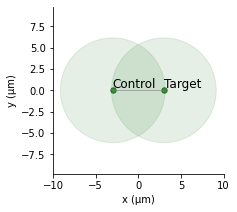

In [ ]:
qubits = {'Control': (-3,0) , 'Target': (3,0) }

Omega_max = pi/2
blockade_radius = Chadoq2.rydberg_blockade_radius(Omega_max)

reg = Register(qubits)
reg.draw(blockade_radius=blockade_radius, 
         draw_half_radius=True, draw_graph = True)

## State prepration

This part of sequence corresponds to preparing the different states on which the CNOT gate will act. For this, we define the following Pulse instances

In [ ]:
#function that takes the label string of a state and turns it into a ket state

def state_prep(sid, basis):
    ids = {'digital': 'ge', 'ground-rydberg': 'rg', 'all': 'rge'}
    
    ket = {k: qutip.basis(len(ids[basis]), i) 
           for i, k in enumerate(ids[basis])}
    
    return qutip.tensor([ket[x] for x in sid])

In [ ]:
state = state_prep('ge', 'digital')
print('Prepared state:')
array_to_latex(state)

Prepared state:


<IPython.core.display.Latex object>

Sequence for state prepration:

In [ ]:
pi_wf = BlackmanWaveform(200, np.pi)
pi_y = Pulse.ConstantDetuning(pi_wf, 0, -np.pi/2)

In [ ]:
def prep_seq(sid, reg):
    global seq
    
    seq = Sequence(reg, Chadoq2)

    #Declare channel
    seq.declare_channel('raman', 'raman_local')
    seq.declare_channel('ryd', 'rydberg_local', 'Control')
    
    if len(sid) != len(reg.qubits):
        raise ValueError('Not a valid state ID.')
    
    seq_dict = {'1':'Target', '0':'Control'}
    
    basis = 'digital'
    if sid == 'gg':
        seq.target('Target','raman')
    else:
        for i in range(len(reg.qubits)):
            if sid[i] == 'e':
                seq.target(seq_dict[str(i)],'raman')
                seq.add(pi_y,'raman')
            
    prep_state = state_prep(sid, basis)
            
    return prep_state

## CNOT Gate sequence

To realize the CNOT gate we apply H gate ($\pi/2$ pulse) before and after the common Cz sequence $\pi-2\pi-\pi$. This five pulse sequence is defined below. 


In [ ]:
#Defining pulses
half_pi_wf = BlackmanWaveform(100, np.pi/2)
half_pi_pulse = Pulse.ConstantDetuning(half_pi_wf, 0, -np.pi/2)#, post_phase_shift=np.pi)
half_pi_pulse_d = Pulse.ConstantDetuning(half_pi_wf, 0, np.pi/2)#, post_phase_shift=np.pi)

pi_pulse = Pulse.ConstantDetuning(pi_wf, 0, 0)

twopi_wf = BlackmanWaveform(300, 2*np.pi)
twopi_pulse = Pulse.ConstantDetuning(twopi_wf, 0, 0)

In [ ]:
def CNOT(int_id):

    #State Preparation
    prep_state = prep_seq(int_id, reg)
    prep_time = max((seq._last(ch).tf for ch in seq.declared_channels), default = 0)
    
    #CNOT Sequence
    seq.target('Target', 'raman')
    seq.add(half_pi_pulse, 'raman')
    seq.align('raman', 'ryd')
    
    seq.add(pi_pulse, 'ryd', 'wait-for-all')
    seq.target('Target', 'ryd')    # Changes to target qubit
    
    #seq.add(pi_pulse, 'ryd')
    #seq.align('raman', 'ryd')

    #seq.add(pi_pulse, 'raman')
    #seq.align('raman', 'ryd')
    
    seq.add(twopi_pulse, 'ryd')
    seq.align('raman', 'ryd')
    
    #seq.add(pi_pulse, 'raman')
    #seq.align('raman', 'ryd')
    
    #seq.add(pi_pulse, 'ryd')
    seq.target('Control', 'ryd')     # Changes back to control qubit
    seq.add(pi_pulse, 'ryd')

    seq.target('Target', 'raman')
    seq.add(half_pi_pulse_d, 'raman')
    seq.align('raman', 'ryd')

        
    seq.measure('digital')

    return prep_state, prep_time

## Visualising sequence


Prepared state-


<IPython.core.display.Latex object>


Preparation time: 200ns

Sequence:-
Channel: raman
t: 0 | Initial targets: Target | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=4.71) | Targets: Target
t: 200->300 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=4.71) | Targets: Target
t: 300->800 | Delay 
t: 800->900 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=1.57) | Targets: Target
t: 900->1000 | Delay 

Channel: ryd
t: 0 | Initial targets: Control | Phase Reference: 0.0 
t: 0->300 | Delay 
t: 300->500 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=0) | Targets: Control
t: 500->500 | Target: Target | Phase Reference: 0.0
t: 500->800 | Pulse(Amp=Blackman(Area: 6.28), Detuning=0 rad/µs, Phase=0) | Targets: Target
t: 800->800 | Target: Control | Phase Reference: 0.0
t: 800->1000 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=0) | Targets: Control

Measured in basis: digital

Plot:-



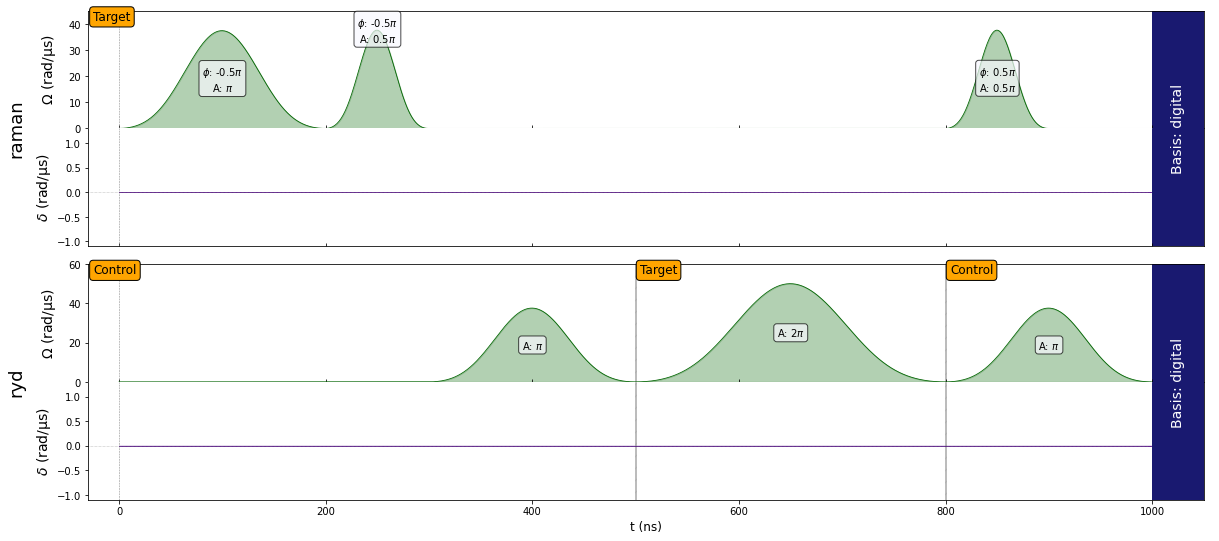

In [ ]:
prep_state, prep_time = CNOT('ge')
print(f'\nPrepared state-')
display(array_to_latex(prep_state))
print(f'\nPreparation time: {prep_time}ns\n')
print(f'Sequence:-\n{seq}')
print('\nPlot:-\n')
seq.draw(draw_phase_area=True)

## Simulating the CNOT sequence

Now we'll simulate the above defined sequence with some error introduced. There are following types of errors can be simulate in Pulser:
- SPAM (State Preparation And Measurement) errors : There are three types of such errors, one (with probability $\eta$) related to bad initial state preparation of the all-ground state $|g\rangle^{\otimes n}$, and two (with probabilities $\epsilon, \epsilon'$ ) linked to detection errors. During the imaging process, excited Rydberg atoms in $|r\rangle$ might decay to the state $|g\rangle$, allowing them to be trapped in the tweezers : those are the false negatives modeled by $\epsilon'$. On the contrary, some atoms in $|g\rangle$ might get excited due to various causes (collisions…) and tweezer recapture might fail, inferring them incorrectly as atoms in $|r\rangle$ : those are the false positives modeled by $\epsilon$.

- Doppler damping : The atoms in the register are cooled to a temperature $T \sim 50\mu K$, which is low but still non-zero. Therefore, the laser frequency they observe is shifted by Doppler shifting due to thermal motion. This corresponds to a shift in the detuning frequency of the laser, and leads to a damping in the Rydberg population. The standard deviation of the doppler noise is $k \times \sqrt{k_b T/M}$, where $k$ is the norm of the effective wavevector of the lasers.  

###### Ref: https://pulser.readthedocs.io/en/latest/tutorials/noisy_sim.html


Here `eta` is the probability of a badly prepared state, `epsilon` the false positive probability (excitation due collisions), `epsilon_prime` the false negative one (decay of rydberg atom to ground state).


For our consideration, the value of `eta: 0.02`, `epsilon: 0.01`, `epsilon_prime: 0.05` and the temperature: $ 100\mu K$.

In [ ]:
def Sim(sid, error=False, error2=False):

    # State prep
    prep_state, prep_time = CNOT(sid) # constructs seq, prep_state and prep_time
    
    print(f"\n\nOutput for the input state '{sid}':-\n\nPrepared state:")
    display(array_to_latex(prep_state))
    print(f'\nPreparation time: {prep_time}ns')

    # Construct Simulation instance
    sim = Simulation(seq)
    if (error==True):
        cfg = SimConfig(noise=('SPAM', 'doppler'),
                      eta=1e-6, epsilon=1e-6/2, epsilon_prime=1e-6*(2.5),runs = 1000) 
        sim.set_config(cfg)

    if (error2==True):
        cfg = SimConfig(noise=('SPAM', 'doppler'), eta=1e-6, runs = 1000) 
        sim.set_config(cfg)


    res = sim.run()
    final_state = res.get_final_state()

    count = res.sample_final_state(N_samples=1e3)
    print(f'\nCounts: {count}\n')
    
    display(plot_histogram(count))
    
    return final_state, count

### Without Error



Output for the input state 'gg':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 0ns

Counts: Counter({'00': 954, '01': 46})



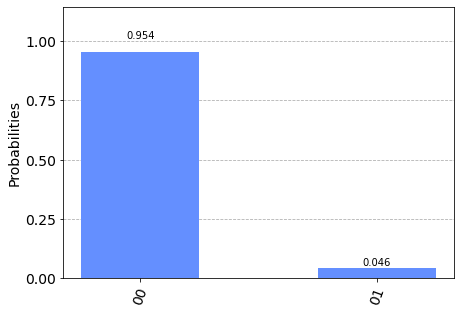



Output for the input state 'ge':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 200ns

Counts: Counter({'01': 936, '00': 64})



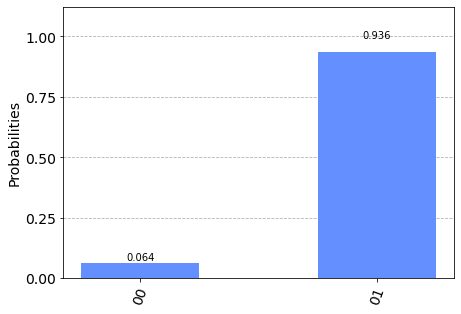



Output for the input state 'eg':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 200ns

Counts: Counter({'11': 1000})



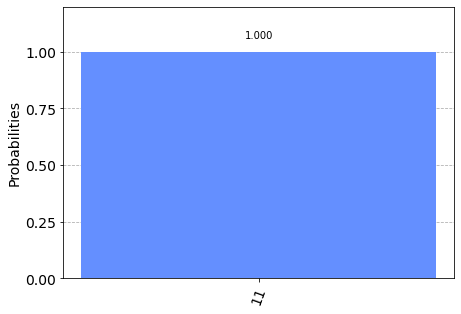



Output for the input state 'ee':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 420ns

Counts: Counter({'10': 1000})



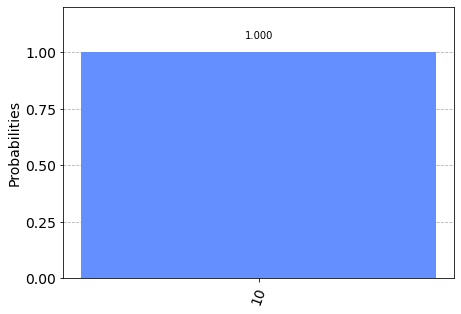

In [ ]:
Input = ['gg','ge','eg','ee']
Output = []
Counts = []

for sid in Input:
    f,c = Sim(sid)
    Output.append(f)
    Counts.append(c)



U_cnot:


<IPython.core.display.Latex object>

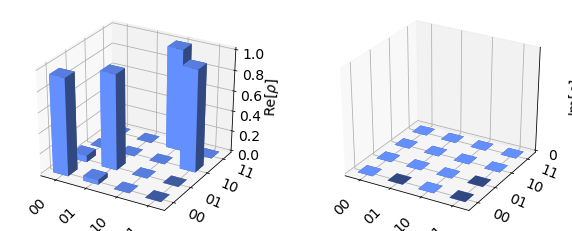

In [ ]:
a1 = np.zeros((4,4));
b = ['00','01','10','11']

for i in range(4):
    for j in range(4):
        k = b[j]
        a1[i][j] = Counts[i][k]/1000

print('\n\nU_cnot:')
display(array_to_latex(a1))

display(plot_state_city(a1, title='', figsize=[10,4]))

### With Some Error



Output for the input state 'gg':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 0ns

Counts: Counter({'00': 945, '01': 55})



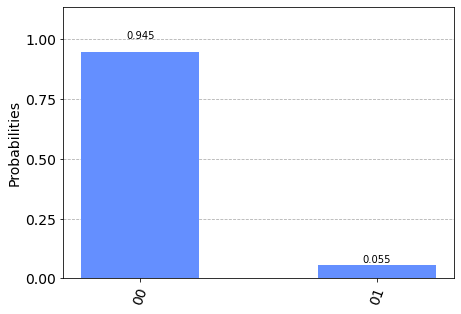



Output for the input state 'ge':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 200ns

Counts: Counter({'01': 937, '00': 63})



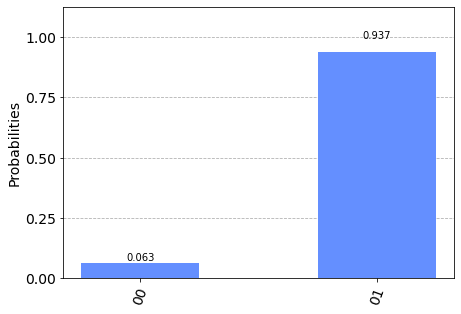



Output for the input state 'eg':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 200ns

Counts: Counter({'11': 996, '10': 3, '00': 1})



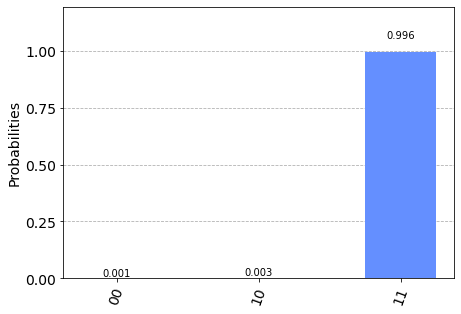



Output for the input state 'ee':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 420ns

Counts: Counter({'10': 999, '01': 1})



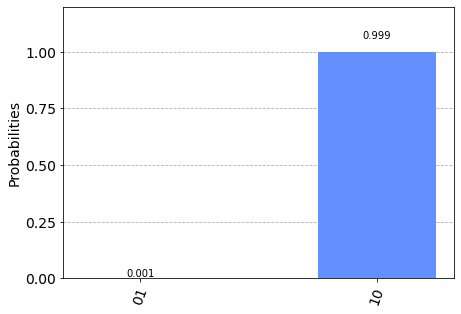

In [ ]:
Output1 = []
Counts1 = []

for sid in Input:
    f,c = Sim(sid, error=True)
    Output1.append(f)
    Counts1.append(c)



U_cnot:


<IPython.core.display.Latex object>

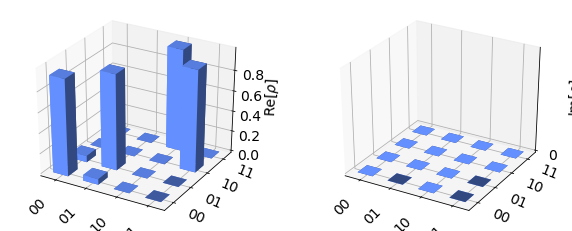

In [ ]:
a2 = np.zeros((4,4));

for i in range(4):
    for j in range(4):
        k = b[j]
        a2[i][j] = Counts1[i][k]/1000

print('\n\nU_cnot:')
display(array_to_latex(a2))

display(plot_state_city(a2, title='', figsize=[10,4]))

### With Some More Error

In [ ]:
Output2 = []
Counts2 = []

for sid in Input:
    f,c = Sim(sid, error2=True)
    Output2.append(f)
    Counts2.append(c)



Output for the input state 'gg':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 0ns


/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ode.py:1014: UserWarning: zvode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  self.messages.get(istate, unexpected_istate_msg)))


Exception: ignored

In [ ]:
u_dag = np.transpose(u)
F2 = np.trace(np.dot(u,a)) / 4
print(f'Fidelity: {F2}')

In [ ]:
a3 = np.zeros((4,4));

for i in range(4):
    for j in range(4):
        k = b[j]
        a3[i][j] = Counts2[i][k]/1000

print('\n\nU_cnot:')
display(array_to_latex(a3))

display(plot_state_city(a3, title='', figsize=[10,4]))

### Fidelity

In [ ]:
u_dag = np.transpose(u)
F = np.trace(np.dot(u,a1))/4
F2 = np.trace(np.dot(u,a2)) / 4
#F3 = np.trace(np.dot(u,a3)) / 4
print(f'Fidelity (without error): {F} \nFidelity (with error parameter 1): {F2} \nFidelity (with error parameter 2): {F3}')

Fidelity (without error): 0.9725 
Fidelity (with error parameter 1): 0.9692500000000001 
Fidelity (with error parameter 2): 0.9692500000000001
